# Portafolios de Inversión
## Proyecto Final

Presenta :

- Juan Ramón López Rocha

- José Armando Melchor Soto

- Paula Ines Pelayo Morales
---



### Librerías


In [5]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import warnings
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch

warnings.filterwarnings('ignore')


---

### Funciones

#### Función Analisis de Acciones

In [6]:
def analizar_brkb():
    ticker_f = "BRK-B"
    accion = yf.Ticker(ticker_f)

    # Obtener datos generales
    info = accion.info
    current_price = info.get('regularMarketPrice', info.get('currentPrice', None))
    book_value_per_share = info.get('bookValue', None)
    trailing_eps = info.get('trailingEps', None)

    if None in (current_price, book_value_per_share, trailing_eps):
        return f"Error: No se pudo obtener alguno de los datos básicos para {ticker_f}."

    price_to_earnings = current_price / trailing_eps

    evaluacion_pe = f"P/E: {price_to_earnings:.2f}. Compara con el S&P 500 (~15–20) para contexto."

    try:
        income_statement = accion.financials
        balance_sheet = accion.balance_sheet

        net_income = income_statement.loc['Net Income Common Stockholders'].iloc[0]
        total_assets = balance_sheet.loc['Total Assets'].iloc[0]
        total_equity = balance_sheet.loc["Total Equity Gross Minority Interest"].iloc[0]

        roa = net_income / total_assets if total_assets else None
        roe = net_income / total_equity if total_equity else None

        roa_str = f"{roa:.2%}" if roa is not None else "N/D"
        roe_str = f"{roe:.2%}" if roe is not None else "N/D"

    except Exception as e:
        roa_str = roe_str = "Error al obtener datos financieros"
        print("Error:", e)

    return (
        f"\nAnálisis de {ticker_f}\n"
        f"Precio Actual: ${current_price:.2f}\n"
        f"EPS (Trailing): ${trailing_eps:.2f}\n"
        f"Price-to-Earnings (P/E): {price_to_earnings:.2f}\n"
        f"ROA: {roa_str}\n"
        f"ROE: {roe_str}\n\n"
    )

In [7]:
def analizar_acciones(ticker_f):
    accion = yf.Ticker(ticker_f)

    # Obtener datos generales
    info = accion.info
    current_price = info.get('regularMarketPrice', info.get('currentPrice', None))
    book_value_per_share = info.get('bookValue', None)
    trailing_eps = info.get('trailingEps', None)

    if None in (current_price, book_value_per_share, trailing_eps):
        return f"Error: No se pudo obtener alguno de los datos básicos para {ticker_f}."

    price_to_earnings = current_price / trailing_eps

    evaluacion_pe = f"P/E: {price_to_earnings:.2f}. Compara con el S&P 500 (~15–20) para contexto."

    try:
        income_statement = accion.financials
        balance_sheet = accion.balance_sheet

        net_income = income_statement.loc['Net Income Common Stockholders'].iloc[0]
        total_assets = balance_sheet.loc['Total Assets'].iloc[0]
        total_equity = balance_sheet.loc["Total Equity Gross Minority Interest"].iloc[0]

        roa = net_income / total_assets if total_assets else None
        roe = net_income / total_equity if total_equity else None

        roa_str = f"{roa:.2%}" if roa is not None else "N/D"
        roe_str = f"{roe:.2%}" if roe is not None else "N/D"

    except Exception as e:
        roa_str = roe_str = "Error al obtener datos financieros"
        print("Error:", e)

    return (
        f"\nAnálisis de {ticker_f}\n"
        f"Precio Actual: ${current_price:.2f}\n"
        f"EPS (Trailing): ${trailing_eps:.2f}\n"
        f"Price-to-Earnings (P/E): {price_to_earnings:.2f}\n"
        f"ROA: {roa_str}\n"
        f"ROE: {roe_str}\n\n"
    )


#### Clase Optimizar Pesos

In [8]:
class OptimizePortfolioWeights:

    def __init__(self, returns: pd.DataFrame, risk_free: float):

        self.rets = returns
        self.cov = returns.cov()
        self.rf = risk_free / 252
        self.n_stocks = len(returns.columns)

    # Min Variance
    def opt_min_var(self):


        var = lambda w: w.T @ self.cov @ w

        w0=np.ones(self.n_stocks)/self.n_stocks

        bounds=[(0, 1)]*self.n_stocks

        constraint=lambda w: sum(w)-1

        result=minimize(fun=var, x0=w0, bounds=bounds,
                        constraints={'fun': constraint, 'type': 'eq'},
                        tol=1e-16)

        return result.x

    # Sharpe Ratio
    def opt_max_sharpe(self):
        rets = self.rets
        rend, cov, rf = self.rets.mean(), self.cov, self.rf

        sr = lambda w: -((np.dot(rend, w) - rf) / ((w.reshape(-1, 1).T @ cov @ w) ** 0.5))

        result = minimize(sr, np.ones(len(rets.T)), bounds=[(0, None)] * len(rets.T),
                          constraints={'fun': lambda w: sum(w) - 1, 'type': 'eq'},
                          tol=1e-16)

        return result.x

    # Semivariance method
    def opt_min_semivar(self, rets_benchmark):

        rets, corr=self.rets.copy(), self.rets.corr()

        diffs=rets-rets_benchmark.values

        below_zero_target=diffs[diffs<0].fillna(0)
        target_downside=np.array(below_zero_target.std())

        target_semivariance=np.multiply(target_downside.reshape(len(target_downside), 1), target_downside) * corr

        semivar = lambda w: w.T @ target_semivariance @ w

        w0=np.ones(self.n_stocks)/self.n_stocks

        bounds=[(0, 1)]*self.n_stocks

        constraint=lambda w: sum(w)-1

        result=minimize(fun=semivar, x0=w0, bounds=bounds,
                        constraints={'fun': constraint, 'type': 'eq'}, tol=1e-16)

        return result.x

    # Omega
    def opt_max_omega(self, rets_benchmark):

        rets=self.rets.copy()

        diffs=rets-rets_benchmark.values

        below_zero_target=diffs[diffs<0].fillna(0)
        above_zero_target=diffs[diffs>0].fillna(0)

        target_downside=np.array(below_zero_target.std())
        target_upside=np.array(above_zero_target.std())
        o=target_upside/target_downside

        omega = lambda w: -sum(o * w)


        w0=np.ones(self.n_stocks)/self.n_stocks

        bounds=[(0.05,0.5)]*self.n_stocks

        constraint=lambda w: sum(w)-1

        result=minimize(fun=omega, x0=w0, bounds=bounds,
                        constraints={'fun': constraint, 'type': 'eq'}, tol=1e-16)

        return result.x


#### Clase Dynamic Backtesting

In [9]:
capital = 1000000

In [10]:
class dynamic_backtesting:

    def __init__(self, prices_tactical, prices_strategic, prices_benchmark, capital, rf, months):
        self.prices_tactical = prices_tactical
        self.prices_strategic = prices_strategic
        self.prices_benchmark = prices_benchmark
        self.capital = capital
        self.rf = rf
        self.months = months

    def optimize_weights(self, prices: pd.DataFrame, n_days: int, periods: int):
        start = int(n_days * periods)
        end = int(n_days * (periods + 1))

        temp_data = prices.iloc[start:end, :]
        temp_bench = self.prices_benchmark.iloc[start:end, :]

        temp_rets = temp_data.pct_change().dropna()
        rets_benchmark = temp_bench.pct_change().dropna()

        optimizer = OptimizePortfolioWeights(returns=temp_rets, risk_free=self.rf)

        w_minvar = pd.Series(optimizer.opt_min_var(), index=prices.columns)
        w_sharpe = pd.Series(optimizer.opt_max_sharpe(), index=prices.columns)
        w_semivar = pd.Series(optimizer.opt_min_semivar(rets_benchmark), index=prices.columns)
        w_omega = pd.Series(optimizer.opt_max_omega(rets_benchmark), index=prices.columns)

        return w_minvar, w_sharpe, w_semivar, w_omega

    def simulation(self):
        total_days = len(self.prices_tactical)
        n_periods = round(total_days / 252 * (12 / self.months))
        n_days = round(total_days / n_periods)

        capital = self.capital

        opt_data = self.prices_tactical.iloc[:n_days, :]
        backtesting_tactical = self.prices_tactical.iloc[n_days:, :]
        backtesting_strategic = self.prices_strategic.iloc[n_days:, :]
        backtesting_benchmark = self.prices_benchmark.iloc[n_days:, :]

        rets_tactical = backtesting_tactical.pct_change().dropna()
        rets_strategic = backtesting_strategic.pct_change().dropna()
        rets_benchmark = backtesting_benchmark.pct_change().dropna()

        min_len = min(len(rets_tactical), len(rets_strategic), len(rets_benchmark))
        rets_tactical = rets_tactical.iloc[:min_len, :]
        rets_strategic = rets_strategic.iloc[:min_len, :]
        rets_benchmark = rets_benchmark.iloc[:min_len, :]

        minvar, sharpe, semivar, omega = [capital], [capital], [capital], [capital]
        day_counter, periods_counter = 0, 0

        w_minvar, w_sharpe, w_semivar, w_omega = self.optimize_weights(opt_data, n_days, 0)

        # Pesos estratégicos fijos uniformes
        w_strategic = pd.Series(
            [1 / self.prices_strategic.shape[1]] * self.prices_strategic.shape[1],
            index=self.prices_strategic.columns
        )

        for day in range(min_len - 1):
            if day_counter == n_days:
                w_minvar, w_sharpe, w_semivar, w_omega = self.optimize_weights(backtesting_tactical, n_days, periods_counter)
                periods_counter += 1
                day_counter = 0

            combined_minvar = w_minvar.add(w_strategic, fill_value=0)
            combined_sharpe = w_sharpe.add(w_strategic, fill_value=0)
            combined_semivar = w_semivar.add(w_strategic, fill_value=0)
            combined_omega = w_omega.add(w_strategic, fill_value=0)

            combined_minvar /= combined_minvar.sum()
            combined_sharpe /= combined_sharpe.sum()
            combined_semivar /= combined_semivar.sum()
            combined_omega /= combined_omega.sum()

            rets_combined = pd.concat([
                rets_tactical.iloc[day, :],
                rets_strategic.iloc[day, :]
            ])

            minvar.append(minvar[-1] * (1 + (rets_combined @ combined_minvar)))
            sharpe.append(sharpe[-1] * (1 + (rets_combined @ combined_sharpe)))
            semivar.append(semivar[-1] * (1 + (rets_combined @ combined_semivar)))
            omega.append(omega[-1] * (1 + (rets_combined @ combined_omega)))

            day_counter += 1

        # Capital acumulado benchmark
        capital_benchmark = capital * (1 + rets_benchmark.sum(axis=1)).cumprod()
        capital_benchmark = capital_benchmark.iloc[:len(minvar)-1]  # igual largo

        df = pd.DataFrame({
            'Date': backtesting_tactical.index[:len(minvar)-1],
            'Min Var': minvar[:-1],
            'Sharpe': sharpe[:-1],
            'Semivar': semivar[:-1],
            'Omega': omega[:-1],
            'Benchmark': capital_benchmark.values
        }).set_index('Date')

        return df




#### Función Métricas de Desempeño

In [11]:
def get_metrics(history, rf):

    # Eliminar columnas completamente NaN
    history_clean = history.dropna(axis=1, how='all')

    # Filtrar columnas con valores no escalares (ej. Series u objetos)
    history_clean = history_clean.loc[:, history_clean.applymap(lambda x: isinstance(x, (int, float, np.float64, np.int64, np.number))).all()]

    # Eliminar columnas con solo un valor único (sin variación)
    history_clean = history_clean.loc[:, history_clean.nunique() > 1]

    # Validar que queden columnas útiles
    if history_clean.empty:
        raise ValueError("El DataFrame de history no tiene columnas válidas para calcular métricas. "
                         "Revisa tus datos o tu simulación.")

    daily_rets = history_clean.pct_change().dropna()
    cov= daily_rets.cov()

    rend_prom = daily_rets.mean() * 252
    std__ = daily_rets.std() * np.sqrt(252)
    RS = (rend_prom - rf) / std__
    downside = daily_rets[daily_rets < 0].fillna(0).std() * np.sqrt(252)
    upside = daily_rets[daily_rets > 0].fillna(0).std() * np.sqrt(252)
    Omega = upside / downside
    Cov_b = cov['Benchmark']
    var_b = Cov_b['Benchmark']
    Beta = Cov_b / var_b

    # Alpha Jensen
    R_m = daily_rets['Benchmark'].mean() * 252
    alpha = rend_prom - (rf + Beta * (R_m - rf))
    # Ratio Treynor
    Treynor = (rend_prom- rf) / Beta

    Sortino = (rend_prom - rf) / downside


    metrics = pd.DataFrame(
        [rend_prom, std__, RS, downside, upside ,Omega,Beta,alpha,Treynor, Sortino],
        index=['Rend', 'Vol', 'R Sharpe', 'Downside', 'Upside','Omega','Beta','Alpha de Jensen','R Treynor','R Sortino']
    )


    return metrics

#### Función Gráfica

In [12]:
def plot_weights_pie(df_percent, strategy_name):
    if strategy_name not in df_percent.columns:
        print(f"'{strategy_name}' no está en las columnas del DataFrame.")
        return

    weights = df_percent[strategy_name]

    # Normalizar a proporción si están en porcentaje (>1.5)
    if weights.max() > 1.5:
        weights = weights / 100

    palette = sns.color_palette('Greys', len(weights))

    labels_for_pie = [
        f"{name} ({weight * 100:.2f}%)" if weight > 0.0001 else ''
        for name, weight in zip(weights.index, weights)
    ]

    legend_labels = [f"{name} ({weight * 100:.2f}%)" for name, weight in zip(weights.index, weights)]

    handles = [mpatches.Circle((0, 0), radius=5, facecolor=color) for color in palette]

    plt.figure(figsize=(10, 6))
    plt.title(f"Estrategia: {strategy_name}", fontsize=16, fontweight='bold')
    plt.pie(
        weights,
        labels=labels_for_pie,
        colors=palette,
        labeldistance=1.05,
        startangle=90
    )
    plt.axis('equal')

    # Leyenda en posición default con círculos y etiquetas completas
    plt.legend(
        handles,
        legend_labels,
        title='Activos',
        fontsize=10,
        handletextpad=0.6,
        labelspacing=0.5,
        borderpad=0.8,
        frameon=False
    )

    plt.tight_layout()
    plt.show()

### EJEMPLO
## plot_weights_pie(combined_df_percentage, 'Mínima Varianza')
#plot_weights_pie(combined_df_percentage, 'Máximo Sharpe')


---

### Obtención de Datos

In [13]:
tickers = yf.download(['BRK-B', 'AZO', 'META','NEM','ED','WMT'], start='2024-04-01', end='2025-07-01' ,progress=False,)['Close']
benchmark = yf.download('^GSPC', start='2024-04-01', end='2025-07-01',progress=False)['Close']

In [14]:
ret = tickers.pct_change().dropna()
rets_benchmark = benchmark.pct_change().dropna()

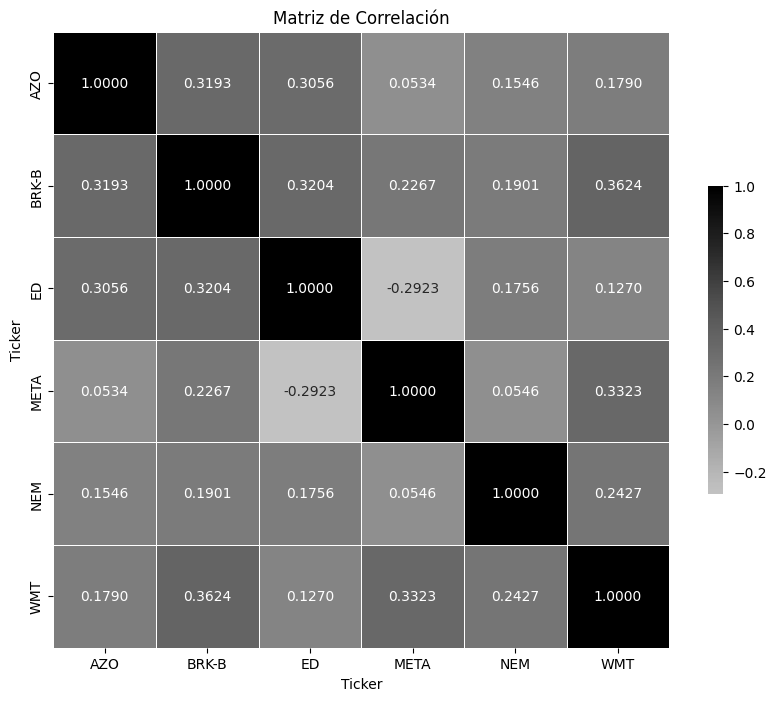

In [15]:
corr = ret.corr()
plt.figure(figsize=(10, 8))

sns.heatmap(corr, annot=True, fmt=".4f", cmap='Greys', center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Matriz de Correlación')
plt.show()

In [16]:
tickers_valuation = ['AZO', 'META','NEM','ED','WMT']
def get_financials(ticker:str) -> pd.DataFrame:
    bs = yf.Ticker(ticker).balance_sheet.iloc[:, :-1]
    ist = yf.Ticker(ticker).income_stmt.iloc[:, :-1]
    cf = yf.Ticker(ticker).cash_flow.iloc[:, :-1]

    return bs, ist, cf

Múltiplos de AZO


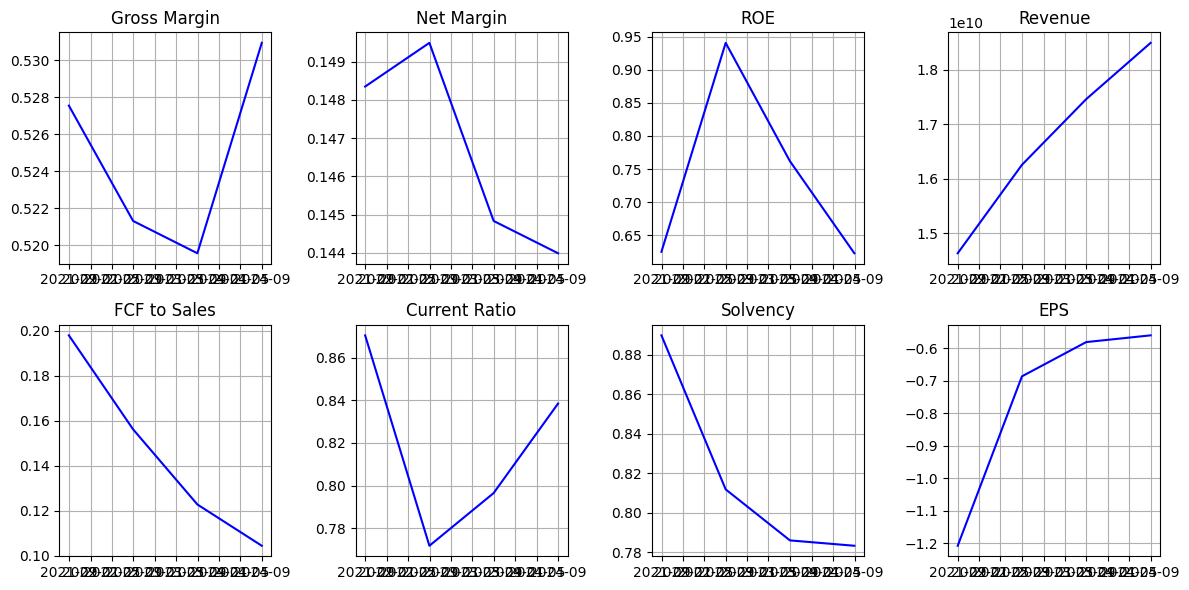

Múltiplos de META


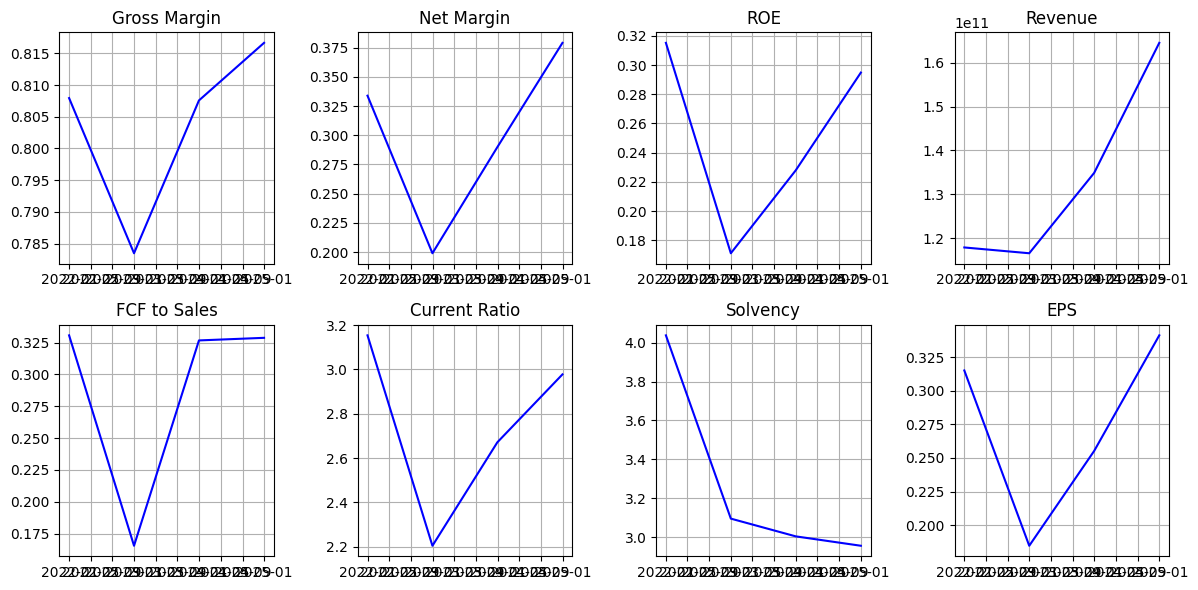

Múltiplos de NEM


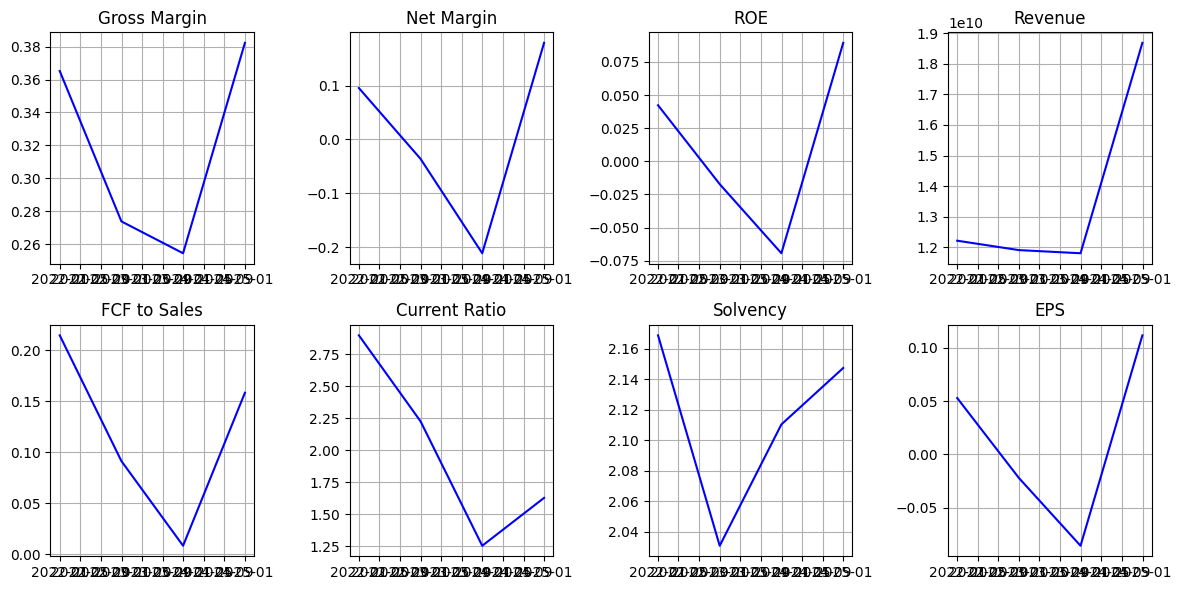

Múltiplos de ED


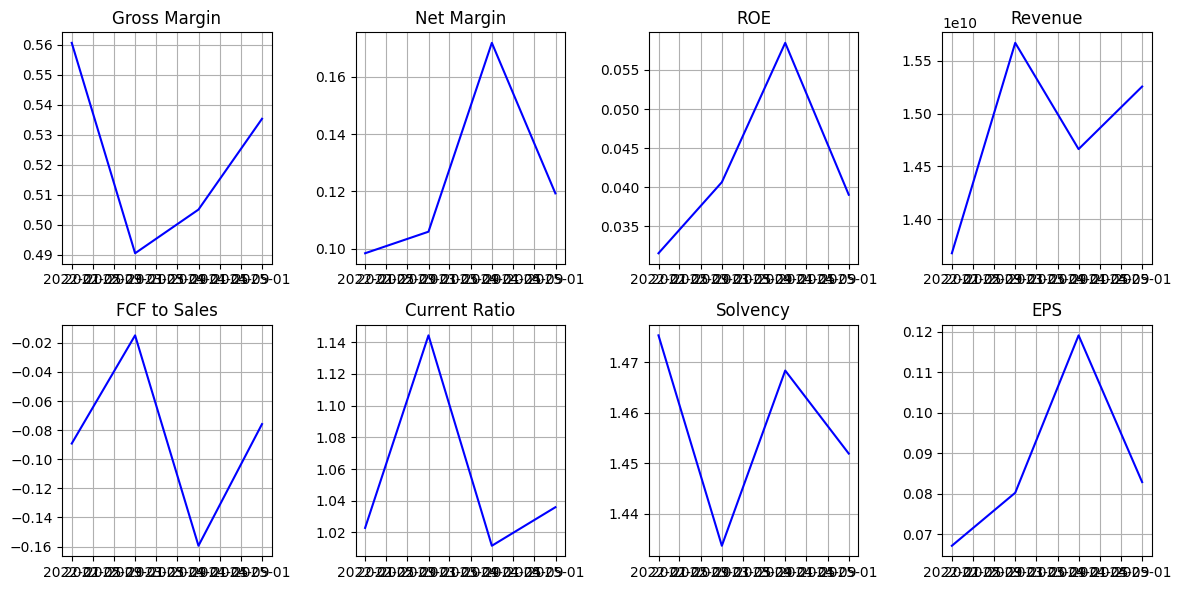

Múltiplos de WMT


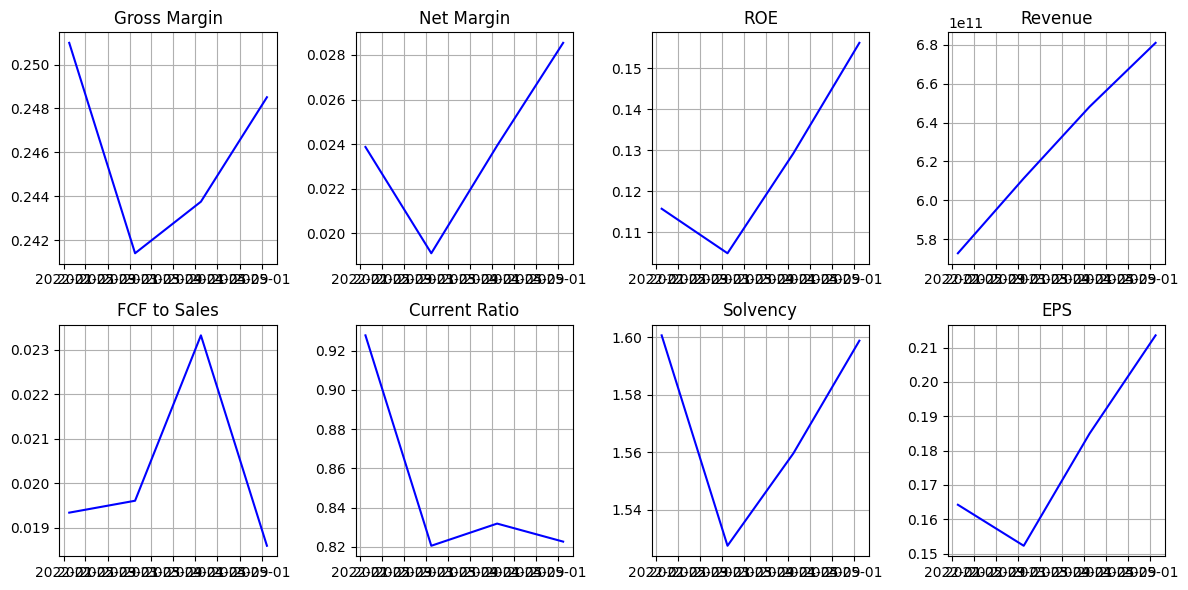

In [17]:
for ticker in tickers_valuation[:5]:

    bs, ist, cf = get_financials(ticker)

    gross_margin = ist.loc['Gross Profit']/ist.loc['Total Revenue']

    net_margin = ist.loc['Net Income Common Stockholders']/ist.loc['Total Revenue']

    roe = ist.loc['Net Income Common Stockholders'] / bs.loc['Total Capitalization']

    revenue = ist.loc['Total Revenue']

    fcf_to_sales = cf.loc['Free Cash Flow'] / ist.loc['Total Revenue']

    current_ratio = bs.loc['Current Assets']/bs.loc['Current Liabilities']

    solvency = bs.loc['Total Assets']/bs.loc['Total Liabilities Net Minority Interest']

    eps = ist.loc['Net Income Common Stockholders'] / bs.loc['Common Stock Equity']

    df_multiplos = pd.DataFrame({
        'Gross Margin': gross_margin,
        'Net Margin': net_margin,
        'ROE': roe,
        'Revenue': revenue,
        'FCF to Sales': fcf_to_sales,
        'Current Ratio': current_ratio,
        'Solvency': solvency,
        'EPS': eps
    })

    df_multiplos.sort_index()

    print(f'Múltiplos de {ticker}')

    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
    axes = axes.ravel()  # Aplana la matriz de ejes para indexar con un solo número

    for i, column in enumerate(df_multiplos.columns):
        axes[i].plot(df_multiplos.index, df_multiplos.iloc[:, i], c = 'blue')
        axes[i].set_title(column)
        axes[i].grid()
    plt.tight_layout()
    plt.show()

In [18]:
print(analizar_brkb())


Análisis de BRK-B
Precio Actual: $471.31
EPS (Trailing): $37.53
Price-to-Earnings (P/E): 12.56
ROA: 7.71%
ROE: 13.66%




In [19]:
print(analizar_acciones("AZO"))


Análisis de AZO
Precio Actual: $3682.62
EPS (Trailing): $147.67
Price-to-Earnings (P/E): 24.94
ROA: 15.50%
ROE: -56.06%




In [20]:
print(analizar_acciones("META"))


Análisis de META
Precio Actual: $702.91
EPS (Trailing): $25.57
Price-to-Earnings (P/E): 27.49
ROA: 22.59%
ROE: 34.14%




In [21]:
print(analizar_acciones("NEM"))


Análisis de NEM
Precio Actual: $58.45
EPS (Trailing): $4.39
Price-to-Earnings (P/E): 13.31
ROA: 5.94%
ROE: 11.12%




In [22]:
print(analizar_acciones("ED"))


Análisis de ED
Precio Actual: $100.46
EPS (Trailing): $5.41
Price-to-Earnings (P/E): 18.57
ROA: 2.58%
ROE: 8.29%




In [23]:
print(analizar_acciones("WMT"))


Análisis de WMT
Precio Actual: $95.15
EPS (Trailing): $2.34
Price-to-Earnings (P/E): 40.66
ROA: 7.45%
ROE: 19.90%




---

## Tactical Asset Allocation

### Optimizar Pesos del Portafolio

In [24]:
optimize_port = OptimizePortfolioWeights(returns=ret, risk_free=0.0445)

#### Optimización Minima Varianza

In [25]:
w_minvar = optimize_port.opt_min_var()*0.5
dict_minvar = dict(zip(ret.columns, w_minvar))
dict_minvar

{'AZO': np.float64(0.08675476672311803),
 'BRK-B': np.float64(0.08932471514989575),
 'ED': np.float64(0.187590286695985),
 'META': np.float64(0.06718339861466598),
 'NEM': np.float64(0.014352501238492518),
 'WMT': np.float64(0.05479433157784274)}

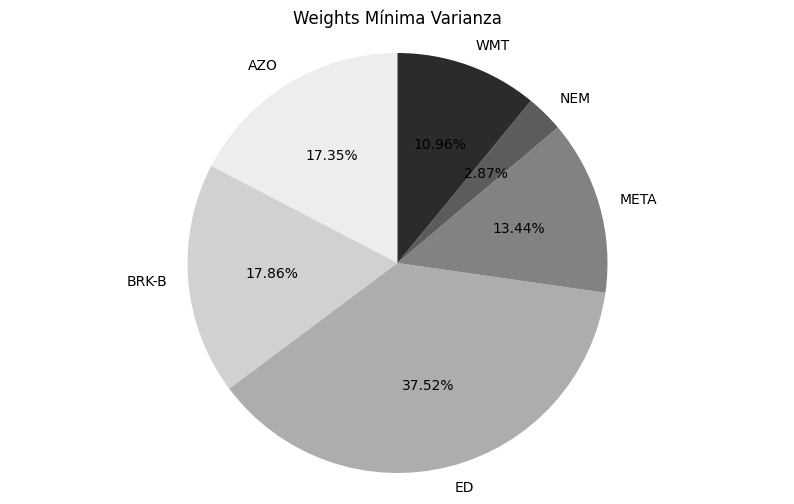

In [26]:
palette = sns.color_palette('Greys', len(w_minvar))

plt.figure(figsize=(10, 6))
plt.pie(
    w_minvar,
    labels=ret.columns,
    colors=palette,
    autopct='%.2f%%',
    startangle=90
)
plt.title('Weights Mínima Varianza')
plt.axis('equal')
plt.show()

#### Optimización Máximo de Sharpe

In [27]:
w_maxsharpe = optimize_port.opt_max_sharpe()*0.5
dict_maxsharpe = dict(zip(ret.columns, w_maxsharpe))
dict_maxsharpe

{'AZO': np.float64(0.0032308180431493707),
 'BRK-B': np.float64(1.3755479641671447e-17),
 'ED': np.float64(0.0876187254491109),
 'META': np.float64(0.07884081056539576),
 'NEM': np.float64(0.08882759402326572),
 'WMT': np.float64(0.24148205191907826)}

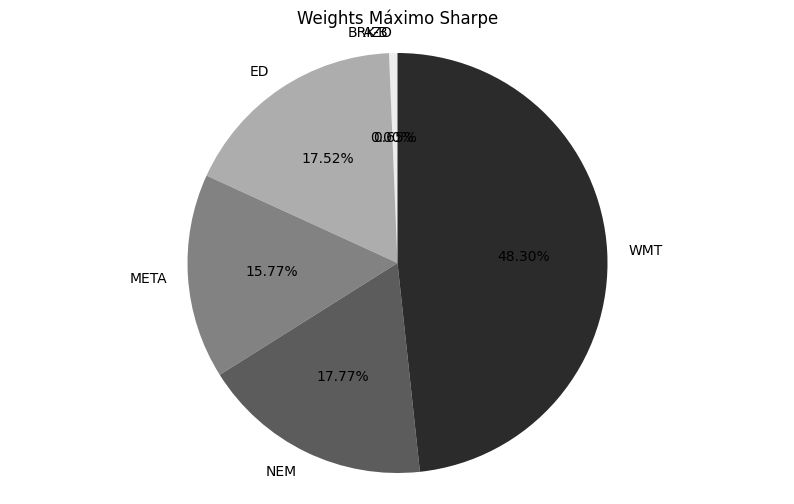

In [28]:
palette = sns.color_palette('Greys', len(w_maxsharpe))

plt.figure(figsize=(10, 6))
plt.pie(
    w_maxsharpe,
    labels=ret.columns,
    colors=palette,
    autopct='%.2f%%',
    startangle=90
)
plt.title('Weights Máximo Sharpe')
plt.axis('equal')
plt.show()

#### Optimización Semi Varianza Target

In [29]:
w_semivar = optimize_port.opt_min_semivar(rets_benchmark)*0.5
dict_semivar = dict(zip(ret.columns, w_semivar))
dict_semivar

{'AZO': np.float64(0.05018921385333963),
 'BRK-B': np.float64(0.17287976894106408),
 'ED': np.float64(0.07794730748540142),
 'META': np.float64(0.09898388902785199),
 'NEM': np.float64(0.01545545830838871),
 'WMT': np.float64(0.08454436238395419)}

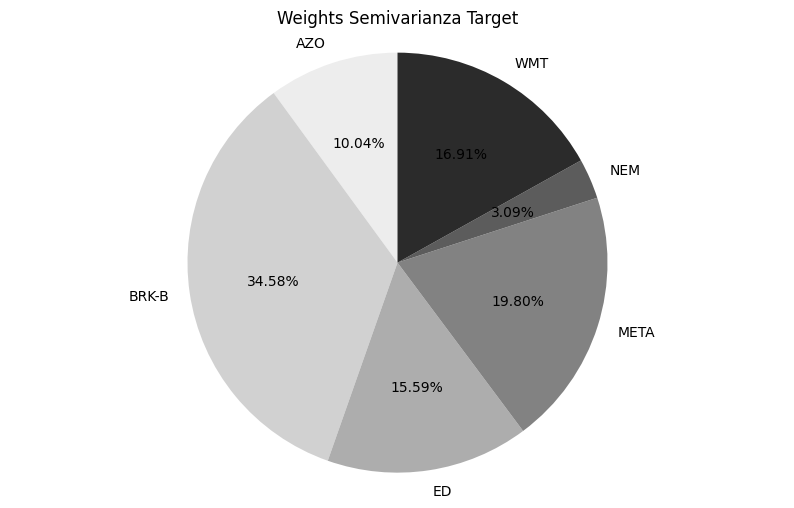

In [30]:
palette = sns.color_palette('Greys', len(w_semivar))

plt.figure(figsize=(10, 6))
plt.pie(
    w_semivar,
    labels=ret.columns,
    colors=palette,
    autopct='%.2f%%',
    startangle=90
)
plt.title('Weights Semivarianza Target')
plt.axis('equal')
plt.show()

#### Optimización Máximo de Omega

In [31]:
omega = optimize_port.opt_max_omega(rets_benchmark)*0.5
dict_omega = dict(zip(ret.columns, omega))
dict_omega

{'AZO': np.float64(0.02500000000000008),
 'BRK-B': np.float64(0.14999999999999977),
 'ED': np.float64(0.025000000000000133),
 'META': np.float64(0.02500000000000002),
 'NEM': np.float64(0.025000000000000067),
 'WMT': np.float64(0.25)}

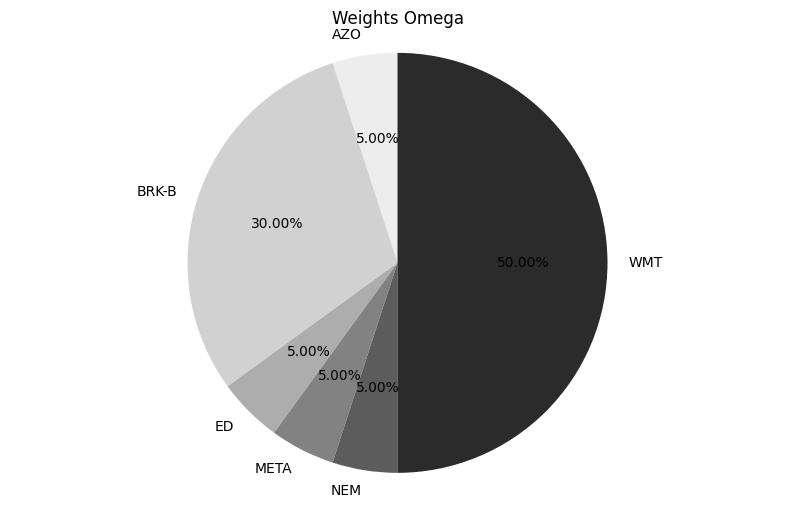

In [32]:
palette = sns.color_palette('Greys', len(omega))

plt.figure(figsize=(10, 6))
plt.pie(
    omega,
    labels=ret.columns,
    colors=palette,
    autopct='%.2f%%',
    startangle=90
)
plt.title('Weights Omega')
plt.axis('equal')
plt.show()

##### Ponderaciones

In [33]:
DataFrame_tactical = pd.DataFrame({
    'Mínima Varianza': dict_minvar,
    'Máximo Sharpe': dict_maxsharpe,
    'Mínimo Semivarianza': dict_semivar,
    'Max Omega': dict_omega
})
DataFrame_tactical

,Mínima Varianza,Máximo Sharpe,Mínimo Semivarianza,Max Omega
AZO,0.086755,3.230818e-03,0.050189,0.025
BRK-B,0.089325,1.375548e-17,0.172880,0.150
ED,0.187590,8.761873e-02,0.077947,0.025
META,0.067183,7.884081e-02,0.098984,0.025
NEM,0.014353,8.882759e-02,0.015455,0.025
WMT,0.054794,2.414821e-01,0.084544,0.250


---

## Strategic Asset Allocation

 ### Obtención de Datos


In [34]:
strategic_prices = yf.download(['SPY'], start='2024-04-01', end='2025-07-01', progress=False)['Close']

In [35]:
returns_strategic = strategic_prices.pct_change().dropna()

### Optimizar portafolio Strategic

In [36]:
optimize_strategic = OptimizePortfolioWeights(returns=returns_strategic, risk_free=0.0445)

#### Optimización Mínima Varianza

In [37]:
w_min_var = optimize_strategic.opt_min_var()*0.5
dict_minvar_strategic = dict(zip(returns_strategic.columns, w_min_var))
dict_minvar_strategic

{'SPY': np.float64(0.5)}

#### Optimización Máximo de Sharpe

In [38]:
w_max_sharpe = optimize_strategic.opt_max_sharpe()*0.5
dict_maxsharpe_strategic = dict(zip(returns_strategic.columns, w_max_sharpe))
dict_maxsharpe_strategic

{'SPY': np.float64(0.5)}

#### Optimización Semivarianza Target

In [39]:
w_semivar_strategic = optimize_strategic.opt_min_semivar(rets_benchmark)*0.5
dict_semivar_strategic = dict(zip(returns_strategic.columns, w_semivar_strategic))
dict_semivar_strategic

{'SPY': np.float64(0.5)}

#### Optimización Máximo Omega

In [40]:
w_omega = optimize_strategic.opt_max_omega(rets_benchmark)
dict_omega_strategic = dict(zip(returns_strategic.columns, w_omega))
dict_omega_strategic

{'SPY': np.float64(0.5)}

##### Ponderaciones

In [41]:
DataFrame_strategic = pd.DataFrame({
    'Mínima Varianza': dict_minvar_strategic,
    'Máximo Sharpe': dict_maxsharpe_strategic,
    'Mínimo Semivarianza': dict_semivar_strategic,
    'Max Omega': dict_omega_strategic
})
DataFrame_strategic*100

,Mínima Varianza,Máximo Sharpe,Mínimo Semivarianza,Max Omega
SPY,50.0,50.0,50.0,50.0


---

### Portafolio

In [42]:
combined_df = DataFrame_tactical.add(DataFrame_strategic, fill_value=0)
combined_df = combined_df.div(combined_df.sum())

Portafolio = combined_df
Portafolio



,Mínima Varianza,Máximo Sharpe,Mínimo Semivarianza,Max Omega
AZO,0.086755,3.230818e-03,0.050189,0.025
BRK-B,0.089325,1.375548e-17,0.172880,0.150
ED,0.187590,8.761873e-02,0.077947,0.025
META,0.067183,7.884081e-02,0.098984,0.025
NEM,0.014353,8.882759e-02,0.015455,0.025
SPY,0.500000,5.000000e-01,0.500000,0.500
WMT,0.054794,2.414821e-01,0.084544,0.250


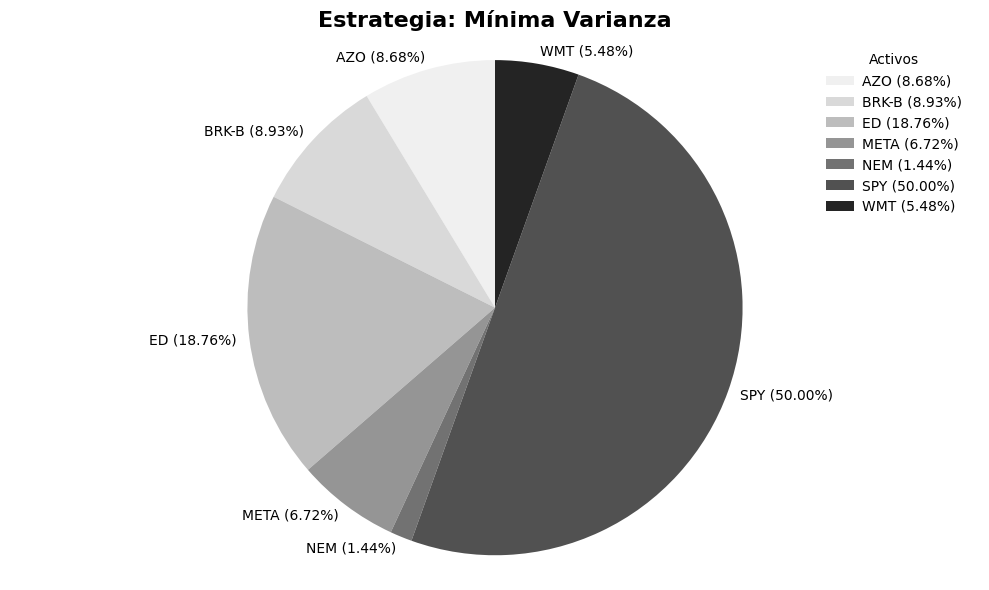

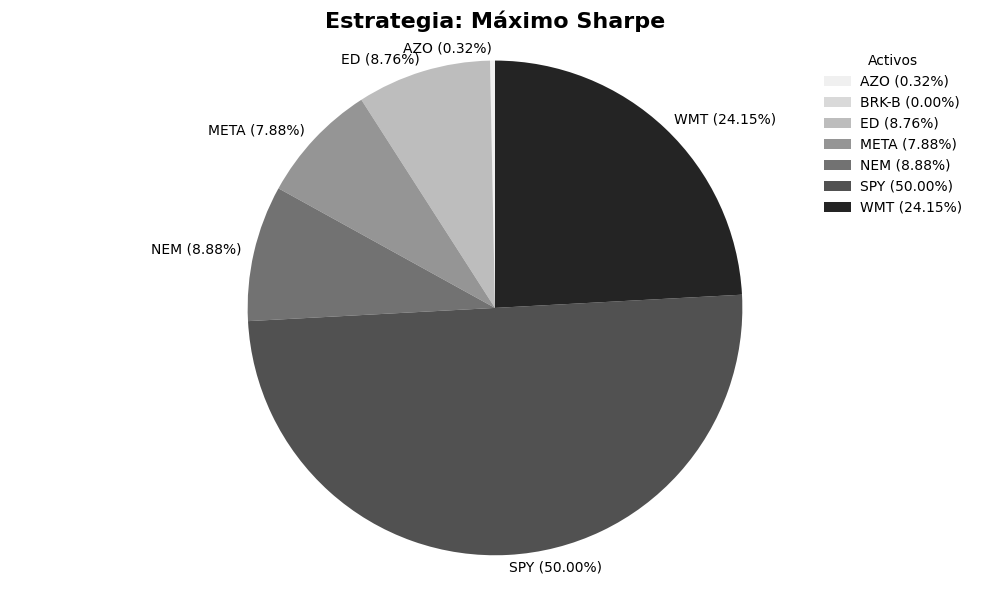

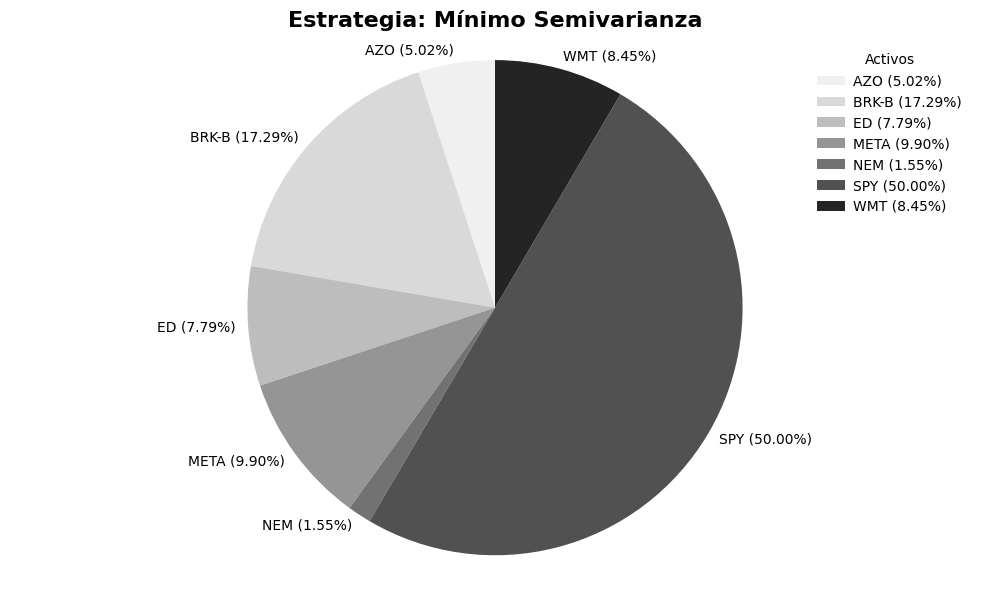

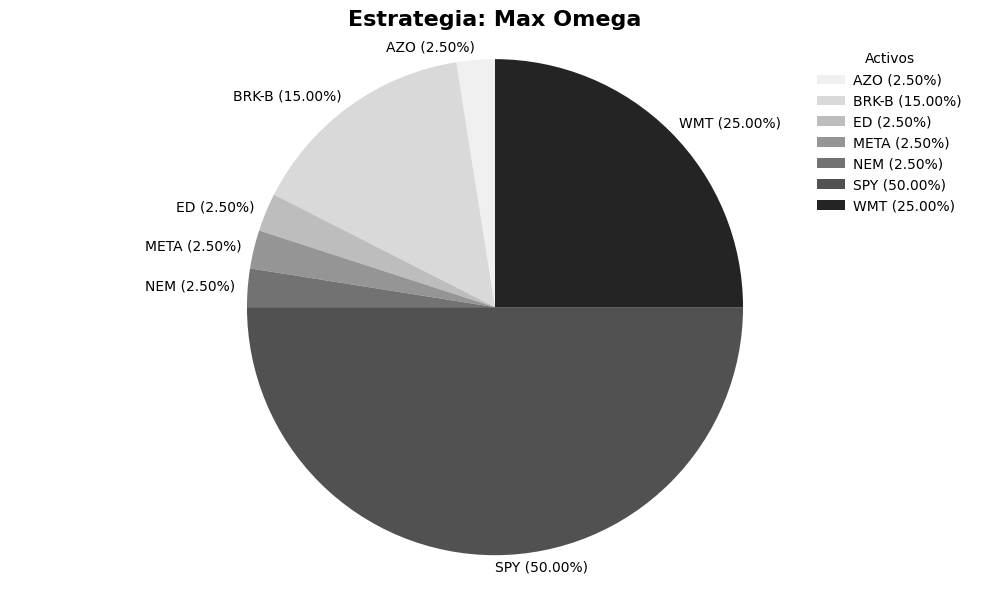

In [43]:
plot_weights_pie(Portafolio, 'Mínima Varianza')
plot_weights_pie(Portafolio, 'Máximo Sharpe')
plot_weights_pie(Portafolio, 'Mínimo Semivarianza')
plot_weights_pie(Portafolio, 'Max Omega')

---

### Backtesting

In [44]:
history = dynamic_backtesting(
    tickers,
    strategic_prices,
    benchmark,
    capital=1000000,
    rf=0.0445,
    months=3
).simulation()
history

,Min Var,Sharpe,Semivar,Omega,Benchmark
Date,,,,,
2024-07-01,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.006195e+06
2024-07-02,1.006645e+06,1.007037e+06,1.006841e+06,1.005767e+06,1.011311e+06
2024-07-03,1.007998e+06,1.014563e+06,1.009189e+06,1.018524e+06,1.016822e+06
2024-07-05,1.018337e+06,1.033498e+06,1.020304e+06,1.033430e+06,1.017855e+06
2024-07-08,1.016289e+06,1.029774e+06,1.018365e+06,1.030336e+06,1.018610e+06
...,...,...,...,...,...
2025-06-20,1.203655e+06,1.138847e+06,1.205528e+06,1.090488e+06,1.100470e+06
2025-06-23,1.216780e+06,1.150982e+06,1.218115e+06,1.099468e+06,1.112709e+06
2025-06-24,1.218375e+06,1.147856e+06,1.218885e+06,1.103826e+06,1.112705e+06


## Visualización Backtesting

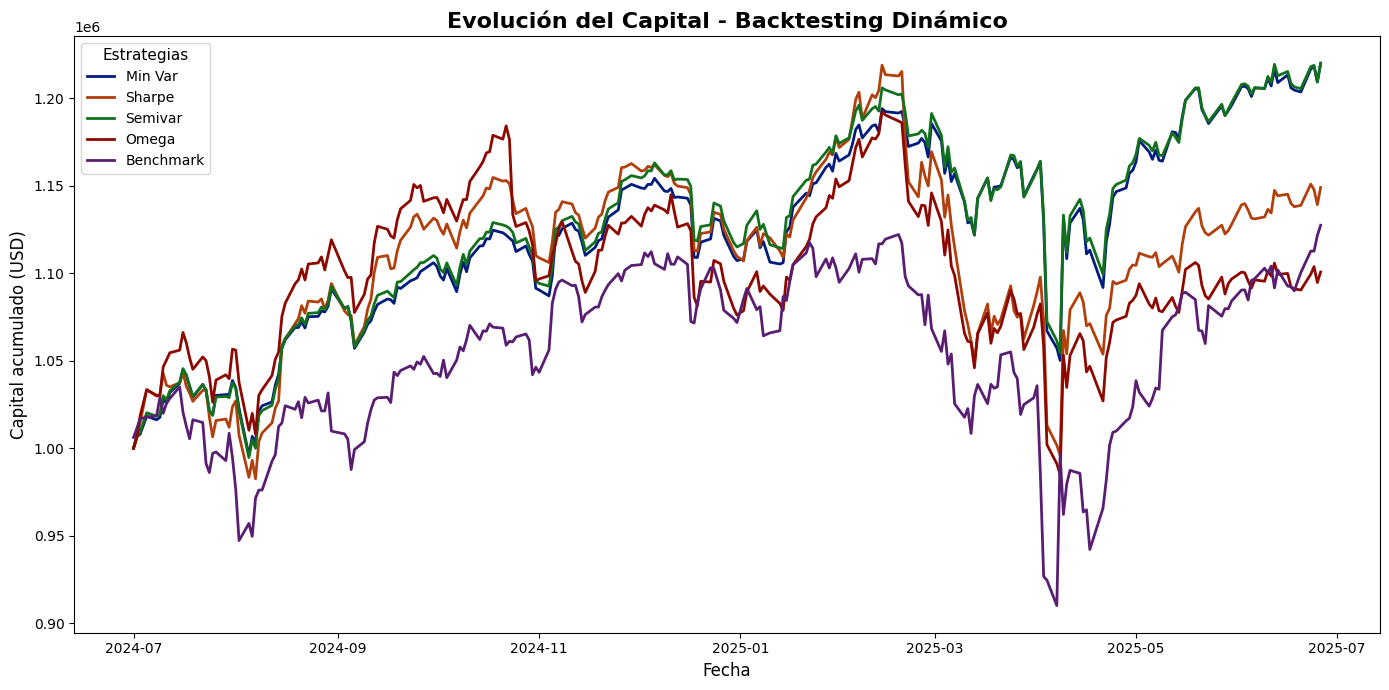

In [45]:
plt.figure(figsize=(14, 7))

colors = sns.color_palette("dark", n_colors=len(history.columns))

for i, col in enumerate(history.columns):
    plt.plot(history.index, history[col], label=col, linewidth=2, color=colors[i])

plt.title('Evolución del Capital - Backtesting Dinámico', fontsize=16, fontweight='bold')
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Capital acumulado (USD)', fontsize=12)

plt.legend(title="Estrategias", loc='upper left', fontsize=10, title_fontsize=11)
plt.tight_layout()
plt.show()


### Métricas de Desempeño del Portafolio de Inversión


In [46]:
metrics_table = get_metrics(history, rf=0.0445)
metrics_table

,Min Var,Sharpe,Semivar,Omega,Benchmark
Rend,0.214863,0.156281,0.214862,0.113179,0.135971
Vol,0.155957,0.170725,0.153645,0.174762,0.200177
R Sharpe,1.092374,0.654747,1.108805,0.392986,0.456950
Downside,0.092857,0.103952,0.091578,0.110302,0.123394
Upside,0.104374,0.107872,0.101730,0.103881,0.128526
Omega,1.124031,1.037715,1.110851,0.941789,1.041588
Beta,-0.042750,-0.021362,-0.042962,-0.045640,1.000000
Alpha de Jensen,0.174274,0.113735,0.174292,0.072854,0.000000
R Treynor,-3.985138,-5.232816,-3.965371,-1.504788,0.091471
R Sortino,1.834690,1.075317,1.860290,0.622648,0.741293


---

# Portafolio minima semivarianza contra el benchmark





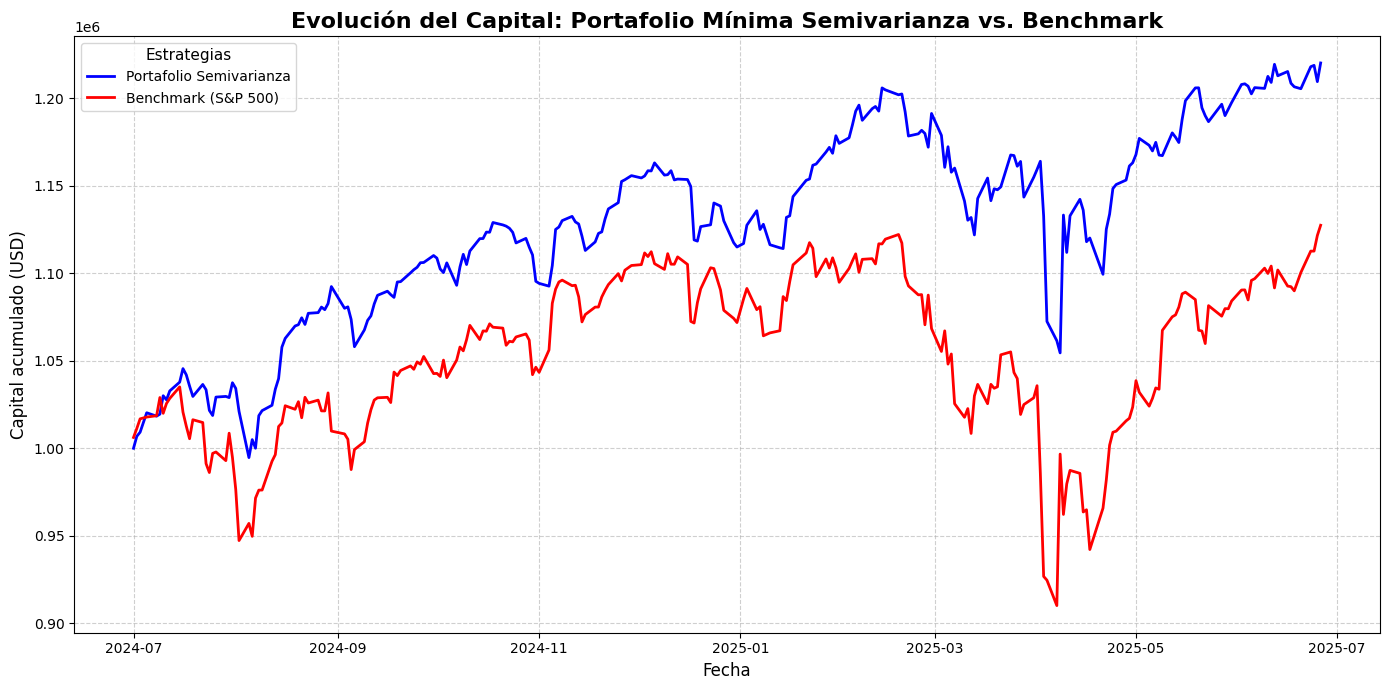

In [47]:
plt.figure(figsize=(14, 7))
plt.plot(history.index, history['Semivar'], label='Portafolio Semivarianza', linewidth=2, color='blue')
plt.plot(history.index, history['Benchmark'], label='Benchmark (S&P 500)', linewidth=2, color='red')

plt.title('Evolución del Capital: Portafolio Mínima Semivarianza vs. Benchmark', fontsize=16, fontweight='bold')
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Capital acumulado (USD)', fontsize=12)
plt.legend(title="Estrategias", loc='upper left', fontsize=10, title_fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
current_prices_data = yf.download(Portafolio.index.tolist(), period="1d", progress=False)

if isinstance(current_prices_data, pd.DataFrame):
    if 'Close' in current_prices_data.columns:
        current_prices = current_prices_data['Close'].iloc[-1]
    else:
        current_prices = current_prices_data.iloc[-1]
elif isinstance(current_prices_data, pd.Series):
     current_prices = current_prices_data
else:
    print(f"Advertencia: El formato de los precios actuales ({type(current_prices_data)}) no es el esperado.")
    current_prices = pd.Series(np.nan, index=Portafolio.index)


if isinstance(current_prices.index, pd.DatetimeIndex):
    if len(current_prices) == len(Portafolio.index):
         current_prices.index = Portafolio.index
    else:
         print("Advertencia: El número de precios descargados no coincide con el número de activos en el portafolio.")
         print("Intentando reindexar por nombre de activo si es posible.")
         if all(item in current_prices_data.columns for item in Portafolio.index):
             current_prices = current_prices_data.iloc[-1].reindex(Portafolio.index)
         else:
              print("Error: No se pudo alinear los precios con los activos del portafolio.")
              current_prices = pd.Series(np.nan, index=Portafolio.index)


capital_min_semivar = capital * Portafolio['Mínimo Semivarianza']


if not current_prices.index.equals(capital_min_semivar.index):
    print("Advertencia: Los índices de los precios actuales y el capital a invertir no coinciden. Alinearndo.")
    current_prices = current_prices.reindex(capital_min_semivar.index)


num_acciones_min_semivar = capital_min_semivar / current_prices
num_acciones_min_semivar = num_acciones_min_semivar.fillna(0).astype(int)
tabla_min_semivarianza = pd.DataFrame({
    'Ponderación (%)': Portafolio['Mínimo Semivarianza'] * 100,
    'Dinero a invertir (USD)': capital_min_semivar.round(2),
    'Número de acciones a comprar': num_acciones_min_semivar
})

print("\nTabla del Portafolio de Mínima Semivarianza:")
display(tabla_min_semivarianza)


Tabla del Portafolio de Mínima Semivarianza:


,Ponderación (%),Dinero a invertir (USD),Número de acciones a comprar
AZO,5.018921,50189.21,13
BRK-B,17.287977,172879.77,366
ED,7.794731,77947.31,775
META,9.898389,98983.89,140
NEM,1.545546,15455.46,264
SPY,50.000000,500000.00,800
WMT,8.454436,84544.36,888


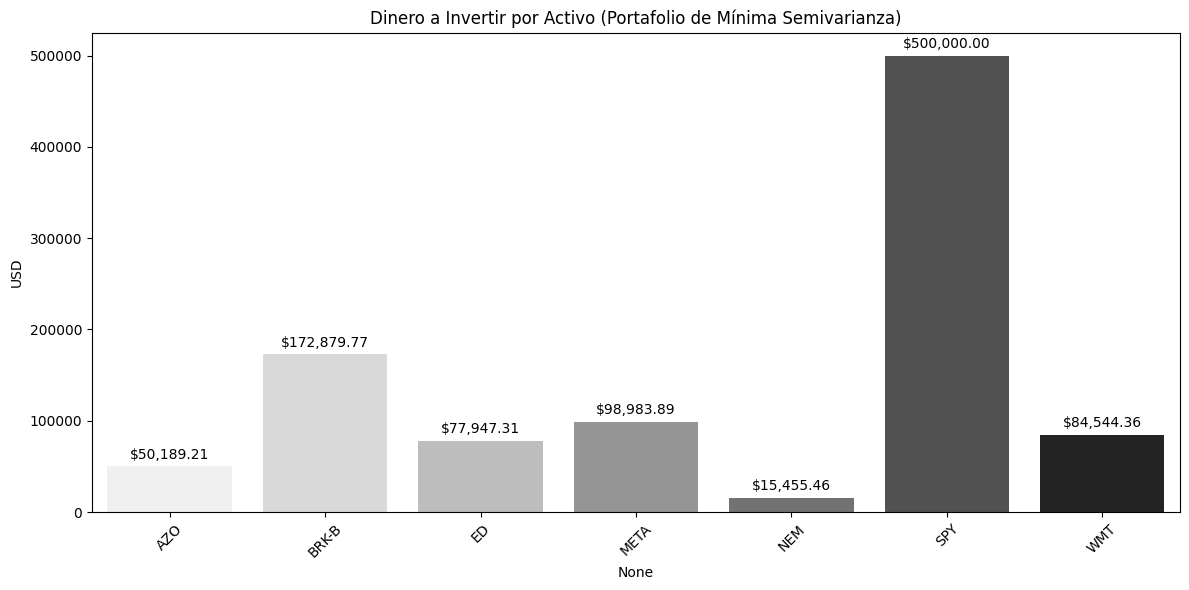

In [49]:

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x=tabla_min_semivarianza.index,
    y=tabla_min_semivarianza['Dinero a invertir (USD)'],
    palette="Greys"
)
plt.xticks(rotation=45)
plt.ylabel('USD')
plt.title('Dinero a Invertir por Activo (Portafolio de Mínima Semivarianza)')

# Añadir etiquetas arriba de cada barra
for i, valor in enumerate(tabla_min_semivarianza['Dinero a invertir (USD)']):
    ax.text(i, valor + max(tabla_min_semivarianza['Dinero a invertir (USD)'])*0.01, 
            f"${valor:,.2f}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

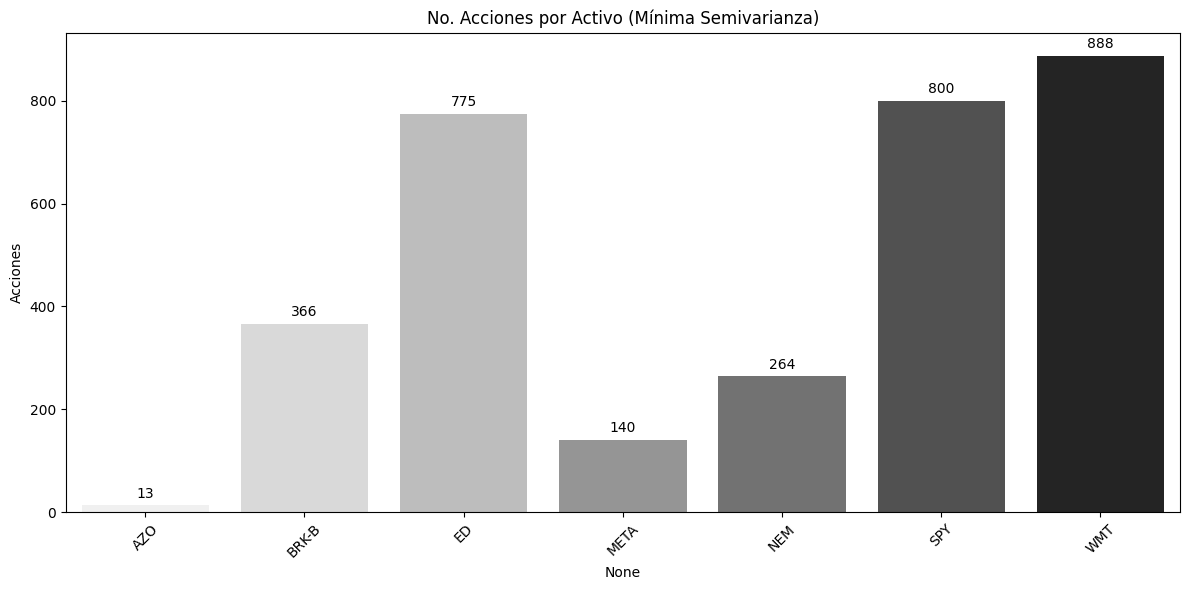

In [50]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x=tabla_min_semivarianza.index,
    y=tabla_min_semivarianza['Número de acciones a comprar'],
    palette="Greys"
)
plt.xticks(rotation=45)
plt.ylabel('Acciones')
plt.title('No. Acciones por Activo (Mínima Semivarianza)')

# Etiquetas arriba de las barras
for i, valor in enumerate(tabla_min_semivarianza['Número de acciones a comprar']):
    ax.text(i, valor + max(tabla_min_semivarianza['Número de acciones a comprar'])*0.01,
            f"{valor}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Conclusión
El proyecto tuvo como finalidad construir un portafolio de inversión eficiente, diversificado y alineado con el perfil de un inversionista adverso al riesgo. Para ello, se desarrolló un modelo cuantitativo que integra principios de la teoría moderna de portafolios, técnicas de optimización bajo distintos criterios de asignación de activos y una estrategia de re balanceo dinámico trimestral. Esta combinación metodológica permitió evaluar de manera realista el comportamiento de diversas estrategias a lo largo del tiempo, en un contexto de mercado cambiante. El portafolio se compuso por seis activos tácticos: “BRK-B”, “AZO”, “META”, “NEM", “ED” y “WMT”. La elección de estos activos se basó en su solidez financiera, su representatividad sectorial y, sobre todo, su baja correlación entre sí, lo que favorece una reducción del riesgo no sistemático. Además, se agregó el ETF “SPY” como activo estratégico, con una asignación fija del 50 %, para capturar de forma diversificada la evolución del mercado estadounidense y aportar una base estable al portafolio. La estructura final permitió una adecuada cobertura frente a distintos ciclos económicos, con exposición tanto a sectores defensivos como de crecimiento. La incorporación del benchmark S&P 500 “GSPC” fue fundamental como referencia de desempeño del mercado, permitiendo contrastar objetivamente la eficiencia y consistencia de cada estrategia frente a un índice ampliamente reconocido, y demostrando que el portafolio optimizado logró superar de manera sostenida a la media del mercado. Desde el punto de vista metodológico, se diseñaron dos clases principales: OptimizePortfolioWeightsy DynamicBacktesting. La primera permitió calcular los pesos óptimos según distintas estrategias: mínima varianza, máxima ratio de Sharpe, mínima semivarianza y Omega. La segunda ejecutó el proceso de simulación y rebalanceo, dividiendo el periodo en ventanas trimestrales. Esta dinámica permitió que el portafolio se ajustará periódicamente a las condiciones del mercado, actualizando las ponderaciones.  La Mínima Semivarianza logró un rendimiento anual del 21.48 %, una volatilidad de solo 15.36 %, y presentó los mejores indicadores ajustados al riesgo: ratio de Sharpe de 1.11, ratio de Sortino de 1.86 y downside risk del 9.15 %, por debajo de todas las demás alternativas. El portafolio final, tras el último rebalanceo, reflejó una combinación eficiente entre activos estratégicos y tácticos. El 50 % se mantuvo en SPY como columna vertebral del portafolio, mientras que el resto se distribuyó principalmente en BRK-B (17.29 %), META (9.90 %), WMT (8.45 %), ED (7.79 %), AZO (5.02 %) y NEM (1.55 %). Esta asignación permitió diversificar entre sectores como tecnología, consumo básico, energía, metales, conglomerados financieros e industrializados, combinando crecimiento con defensividad y cobertura inflacionaria. El rebalanceo trimestral fue clave para el éxito de la estrategia. Permitió ajustar el portafolio a los cambios en correlaciones y volatilidades sin realizar operaciones innecesarias, conservando así una estructura eficiente a lo largo del tiempo. Esta práctica, inspirada en una gestión institucional, mejoró la consistencia del portafolio, redujo desbalances naturales por acumulación de rendimiento, y mantuvo el alineamiento con los objetivos del inversionista.

En contraste, las estrategias de Máximo Sharpe y Omega, aunque prometedoras en teoría, mostraron menor estabilidad. El portafolio Sharpe se expuso de forma desproporcionada a activos con mayor volatilidad, lo que deterioró su desempeño en entornos bajistas. Por su parte, el portafolio Omega resultó altamente sensible al retorno objetivo, perdiendo consistencia y eficiencia en el tiempo. El benchmark, por su parte, aunque útil como referencia, no logró competir en métricas ajustadas al riesgo, ni tampoco en rentabilidad acumulada frente a la estrategia seleccionada.

En conclusión, la estrategia de Mínima Semivarianza con rebalanceo trimestral demostró ser la más sólida, rentable y consistente. No solo superó al benchmark en rendimientos, sino que también protegió eficazmente el capital frente a la volatilidad. Esta estrategia combinó la eficiencia cuantitativa de la optimización con una disciplina operativa mediante rebalanceo, y una selección de activos estratégicamente diversificada con baja correlación. Por lo tanto, representa una propuesta financieramente robusta, teóricamente sustentada y prácticamente aplicable para la gestión profesional de inversiones en escenarios reales.